In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

# Cloning repo

In [2]:
!git clone https://github.com/rohan1827/Lip-lense.git

Cloning into 'Lip-lense'...
remote: Enumerating objects: 2037, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 2037 (delta 7), reused 17 (delta 1), pack-reused 2006 (from 1)
Receiving objects: 100% (2037/2037), 408.56 MiB | 18.08 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Updating files: 100% (2008/2008), done.


# Setting up training data

In [3]:
# checking the directory
!ls Lip-lense/demo-data/

# changing the current working directory
import os
os.chdir('/content/Lip-lense')

# copying videos and alignments files to a different location for ease of access
!cp -r '/content/Lip-lense/demo-data/videos/s1' /content/videosFiles/
!cp -r '/content/Lip-lense/demo-data/s1' /content/alignmentsFiles/


s1  videos


# 1. Preprocessing

In [4]:
# function to load the video from its path and preprocess it
def load_video(path:str) -> List[float]:
  cap = cv2.VideoCapture(path)
  frames = []
  for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret, frame = cap.read()
    frame = tf.image.rgb_to_grayscale(frame)
    # cropping
    frames.append(frame[190:236,80:220,:])

  cap.release()

  mean = tf.math.reduce_mean(frames)
  std = tf.math.reduce_std(tf.cast(frames, tf.float32))
  return tf.cast((frames - mean), tf.float32) / std

In [5]:
# helper functions for text preprocessing
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

# using keras tools
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

# testing
print(
    f"The vocabulary is: {char_to_num.get_vocabulary()}\n "
    f"(size ={char_to_num.vocabulary_size()})"
)

# testing the helper functions
(print('Encoded (python):',char_to_num(['p','y','t','h','o','n'])))
(print('Decoded (python):',tf.strings.reduce_join(num_to_char(char_to_num(['p','y','t','h','o','n']))).numpy().decode('utf-8')))

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']
 (size =40)
Encoded (python): tf.Tensor([16 25 20  8 15 14], shape=(6,), dtype=int64)
Decoded (python): python


In [6]:
# function to load text files from path
def load_alignments(path:str) -> List[str]:
    # reading
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [7]:
# combining video and alignments preprocessing functions

def load_data(path: str):
    path = bytes.decode(path.numpy())
    # in linux need to use forward slash
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows

    # file_name = path.split('\')[-1].split('.')[0]
    # mention the folder of videos and alignments

    video_path = os.path.join('/content','videosFiles',f'{file_name}.mpg')
    alignment_path = os.path.join('/content','alignmentsFiles',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [8]:
test_path = '/content/videosFiles/bbaf2n.mpg'

In [9]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [10]:
len(frames), len(alignments)

(75, 21)

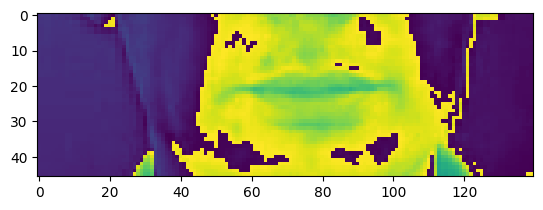

In [11]:
# visualizing
plt.imshow(frames[55])

In [12]:
# alignments decoding
num_to_char(alignments.numpy())

<tf.Tensor: shape=(21,), dtype=string, numpy=
array([b'b', b'i', b'n', b' ', b'b', b'l', b'u', b'e', b' ', b'a', b't',
       b' ', b'f', b' ', b't', b'w', b'o', b' ', b'n', b'o', b'w'],
      dtype=object)>

In [13]:
# bytes decode and join
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [14]:
# function to run preprocessing function (in py) inside TF pipeline
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2 .Create Data Pipeline

In [15]:
# data loading pipeline
data = tf.data.Dataset.list_files('/content/videosFiles/*.mpg') # stores all the files in the videoFiles folder that ends with '.mpg' ext
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function) # execute the preprocessing function (load_data())

# pick data as a batch of two
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

# Added for split
train = data.take(450)
test = data.skip(450)

In [16]:
# get the next files using iteration
frames,alignments = data.as_numpy_iterator().next()

In [17]:
alignments

array([[ 2,  9, 14, 39, 23,  8,  9, 20,  5, 39, 23,  9, 20,  8, 39,  2,
        39, 15, 14,  5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  9, 14, 39,  2, 12, 21,  5, 39,  9, 14, 39, 12, 39,  6,  9,
        22,  5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [18]:
len(frames)

2

# 3. Neural Net Architecture

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [20]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [33]:
# # Design reference: 'LIP-NET'

model = Sequential()
# model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D((1,2,2)))

# model.add(Conv3D(256, 3, padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D((1,2,2)))

# model.add(Conv3D(75, 3, padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPool3D((1,2,2)))

# model.add(TimeDistributed(Flatten()))

# model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
# model.add(Dropout(.5))

# model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
# model.add(Dropout(.5))

# model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

# First Conv3D Block
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

# Second Conv3D Block
model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

# Third Conv3D Block
model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

# Reshape before TimeDistributed
# Calculate the correct shape after Conv3D and MaxPool3D operations
# Original: (75, 46, 140) -> After MaxPool3D operations: (75, 5, 17)
model.add(Reshape((75, -1)))  # Flatten spatial dimensions while keeping time dimension

# LSTM layers
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

# Output layer
model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [34]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_6 (Conv3D)                    │ (None, 75, 46, 140, 128)    │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 75, 46, 140, 128)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_6 (MaxPooling3D)       │ (None, 75, 23, 70, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_7 (Conv3D)                    │ (None, 75, 23, 70, 256)     │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 75, 23, 70, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_7 (MaxPooling3D)       │ (None, 75, 11, 35, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_8 (Conv3D)                    │ (None, 75, 11, 35, 75)      │         518,475 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 75, 11, 35, 75)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_8 (MaxPooling3D)       │ (None, 75, 5, 17, 75)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 75, 6375)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 75, 256)             │       6,660,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 75, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 75, 41)              │          10,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

**Total params of this model will be about 8.5M**

# 4. Training Loop

In [36]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [37]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [38]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [39]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [40]:
checkpoint_callback = ModelCheckpoint(
    os.path.join('models', 'checkpoint.weights.h5'),  # Added '.weights.h5' to the filename
    monitor='loss',
    save_weights_only=True)

In [41]:
schedule_callback = LearningRateScheduler(scheduler)

In [42]:
example_callback = ProduceExample(test)

In [43]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
Original: bin green at a seven soon
Prediction: le e e e e e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set red at h six please
Prediction: le e e e e e
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 901s 2s/step - loss: 101.2786 - val_loss: 69.7462 - learning_rate: 1.0000e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Original: set white in h nine again
Prediction: la e e e e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue in n zero please
Prediction: la e e e e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 ━━━━━━━━━━━━━━━━━━━━ 681s 2s/step - loss: 72.2800 - val_loss: 66.6570 - learning_rate: 1.0000e-04
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 

UnknownError: Graph execution error:

Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) UNKNOWN:  Error in user-defined function passed to MapDataset:3 transformation with iterator: Iterator::Root::Prefetch::FiniteTake::Prefetch::PaddedBatchV2::Map: InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 103680 values, but the requested shape has 311040 [Op:Reshape]
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "<ipython-input-7-8bb53b1265b2>", line 14, in load_data
    frames = load_video(video_path)

  File "<ipython-input-4-0005f0b6ef29>", line 7, in load_video
    frame = tf.image.rgb_to_grayscale(frame)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 103680 values, but the requested shape has 311040 [Op:Reshape]


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/ctc_loss/Shape_1/_86]]
  (1) UNKNOWN:  Error in user-defined function passed to MapDataset:3 transformation with iterator: Iterator::Root::Prefetch::FiniteTake::Prefetch::PaddedBatchV2::Map: InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 103680 values, but the requested shape has 311040 [Op:Reshape]
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "<ipython-input-7-8bb53b1265b2>", line 14, in load_data
    frames = load_video(video_path)

  File "<ipython-input-4-0005f0b6ef29>", line 7, in load_video
    frame = tf.image.rgb_to_grayscale(frame)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 103680 values, but the requested shape has 311040 [Op:Reshape]


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_35814]